DESCRIBE THE CODE AND HOW IT IS BUILT

# IMPORTS

In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, Image
from keras.utils.vis_utils import plot_model

# GENERATED HELPER METHODS

## LOAD DATA & PREPARE THE DATA

In [2]:
def data_loader(url):
  dataset = pd.read_csv(url)
  
  # Plot the original data
  '''
  plt.figure(figsize=(15, 8))
  plt.title('Apple Stock Prices History')
  plt.plot(dataset['Close'])
  plt.xlabel('Date')
  plt.ylabel('Prices ($)')
  '''
  
  # Get only the close values
  close_prices = dataset['Close']
  values = close_prices.values 

  # Normalize the data.  
  scaler = MinMaxScaler(feature_range=(0,1))
  values = scaler.fit_transform(values.reshape(-1, 1))

  # Split data & labels - For data, each input is the previous 60 days. 
  data = []
  labels = []
  for i in range(60, len(values)):
    data.append(values[i-60:i, 0])
    labels.append(values[i, 0])
  data = np.array(data).reshape(-1, 60, 1)
  labels = np.array(labels).reshape(-1, 1)

  # Split the data into Train & Test Subsets
  x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, shuffle=False)

  return x_train, y_train, x_test, y_test, scaler


## BUILD THE MODEL

In [3]:
def generate_model(input_size, output_size):
  model = keras.Sequential()
  model.add(layers.GRU(100, return_sequences=True, input_shape=input_size))
  model.add(layers.GRU(100, return_sequences=False))
  model.add(layers.Dense(25))
  model.add(layers.Dense(output_size))
  return model 

## EVALUATE THE MODEL

In [4]:
def evaluate_model(x_test, y_test):
  predictions = model.predict(x_test)
  predictions = scaler.inverse_transform(predictions)
  y_test = scaler.inverse_transform(y_test)
  rmse = np.sqrt(np.mean(predictions - y_test)**2)
  print(rmse)
  return predictions, rmse, y_test

## GENERATE THE REPORT

In [5]:
def generate_results_report(predictions, rmse, history, scaler, y_train, y_test):
  # Loss
  loss = history.history['loss']
  epochs = range(1, len(loss) + 1)
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.title('Training loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  y_train = scaler.inverse_transform(y_train)

  # Plot the results
  plt.figure(figsize=(16,8))
  plt.title('Model')
  plt.xlabel('Date')
  plt.ylabel('Close Price USD ($)')
  plt.plot(range(len(y_train)), y_train)
  plt.plot(range(len(y_train), len(y_train)+len(y_test)), y_test)
  plt.plot(range(len(y_train), len(y_train)+len(y_test)), predictions)
  plt.legend(['Real Data', 'Real value for predictions', 'Predicted data'], loc='lower right')
  plt.show()

  # Plot the model
  plot_model(model, to_file='LSTM_plot.png', show_shapes=True, show_layer_names=True)
  display(Image(filename='LSTM_plot.png'))

  return 0

# MAIN

In [6]:
url = "/content/drive/MyDrive/Machine Learning -Fall 22'/FinalProject/AAPL.csv"
x_train, y_train, x_test, y_test, scaler = data_loader(url)
model = generate_model(input_size=(x_train.shape[1], 1), output_size=y_train.shape[1])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), loss=tf.keras.losses.MeanSquaredError(), metrics=['MSE'])
history = model.fit(x_train, y_train, batch_size = 1, epochs = 5, verbose=1)
predictions, rmse, y_test = evaluate_model(x_test, y_test)

Epoch 1/5
8326/8326 [==============================] - 70s 8ms/step - loss: 5.8802e-06 - MSE: 5.8802e-06
Epoch 2/5
8326/8326 [==============================] - 64s 8ms/step - loss: 2.4236e-06 - MSE: 2.4236e-06
Epoch 3/5
8326/8326 [==============================] - 63s 8ms/step - loss: 2.0113e-06 - MSE: 2.0113e-06
Epoch 4/5
8326/8326 [==============================] - 63s 8ms/step - loss: 1.7337e-06 - MSE: 1.7337e-06
Epoch 5/5
66/66 [==============================] - 1s 4ms/step
0.061782268875576384


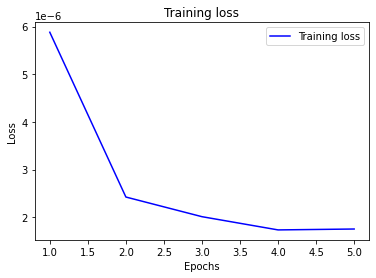

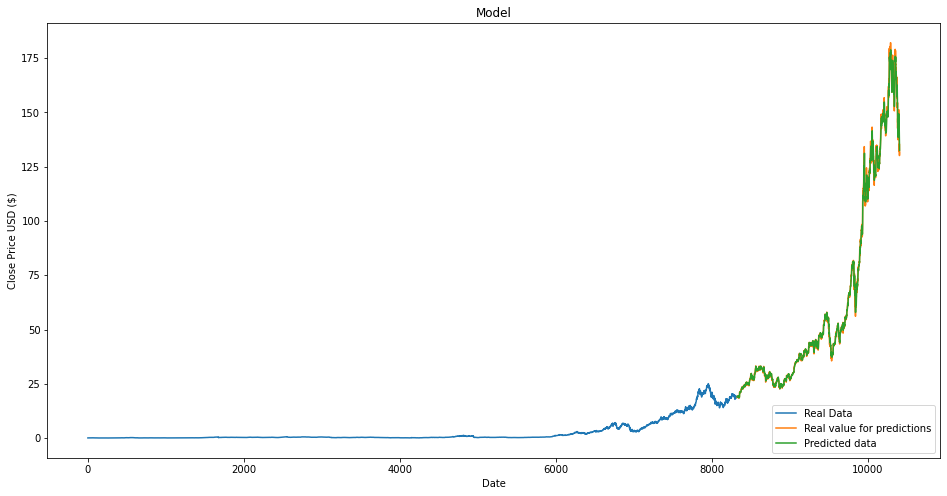

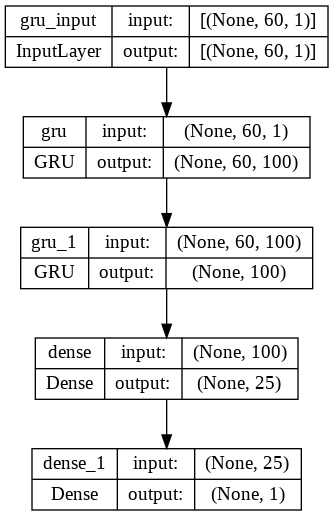

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 100)           30900     
                                                                 
 gru_1 (GRU)                 (None, 100)               60600     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 94,051
Trainable params: 94,051
Non-trainable params: 0
_________________________________________________________________


In [7]:
generate_results_report(predictions, rmse, history, scaler, y_train, y_test)
model.summary()